In [4]:
library(tidyverse)
library(ape)
library(TreeSim)
library(phytools)
library(mvtnorm)
library(phylolm)
library(broom)
library(scales)
library(VGAM)
library(sn)
library(moments)
library(vroom)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘ape’


The following object is masked from ‘package:dplyr’:

    where


Loading required package: geiger

Loading required package: phytools

Loading required package: maps


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

 

In [5]:
options(jupyter.plot_scale=1) 

In [6]:
#Simulate divergence times
s1 = stree(100,type="star")
s2 = stree(100,type="star")
s1$tip.label = paste(s1$tip.label,"_1")
s2$tip.label = paste(s2$tip.label,"_2")
s1$edge.length=rep(1,length(s1$tip.label))
s2$edge.length=rep(1,length(s2$tip.label))

num_rep = 100
divergence = 10^(seq(log10(1e-4),log10(1),len=10))

p_vals = tibble()

for (i in 1:length(divergence)) {
    message(i)
    s1$root.edge=divergence[i]
    s2$root.edge=divergence[i]
    
    combined_tree = s1+s2
    
    PC1 = eigen(vcv(combined_tree))$vectors[,1]

    for (j in 1:num_rep) {
        BM = fastBM(combined_tree,1,nsim=2)
        X = BM[,1]
        Y = BM[,2]
        
        
        all_data = as.data.frame(tibble(X = X, Y = Y,PC1=PC1))
        rownames(all_data) = rownames(BM)
        
        cur_lm = lm(Y ~ X,data=all_data)
        cur_p = summary(cur_lm)$coefficients["X","Pr(>|t|)"]
        p_vals = bind_rows(p_vals,tibble(divergence=divergence[i],p.value=cur_p,rep=j,method="lm"))
        
        cur_lm = lm(Y ~ X + PC1,data=all_data)
        cur_p = summary(cur_lm)$coefficients["X","Pr(>|t|)"]
        p_vals = bind_rows(p_vals,tibble(divergence=divergence[i],p.value=cur_p,rep=j,method="lm_PC"))
        
        cur_lm = phylolm(Y ~ X,data=all_data,phy=combined_tree)
        cur_p = summary(cur_lm)$coefficients["X","p.value"]
        p_vals = bind_rows(p_vals,tibble(divergence=divergence[i],p.value=cur_p,rep=j,method="phylolm"))
        
        cur_lm = phylolm(Y ~ X + PC1,data=all_data,phy=combined_tree)
        cur_p = summary(cur_lm)$coefficients["X","p.value"]
        p_vals = bind_rows(p_vals,tibble(divergence=divergence[i],p.value=cur_p,rep=j,method="phylolm_PC"))
        
    }
    
}

1

2

3

4

5

6

7

8

9

10



`summarise()` has grouped output by 'method'. You can override using the `.groups` argument.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


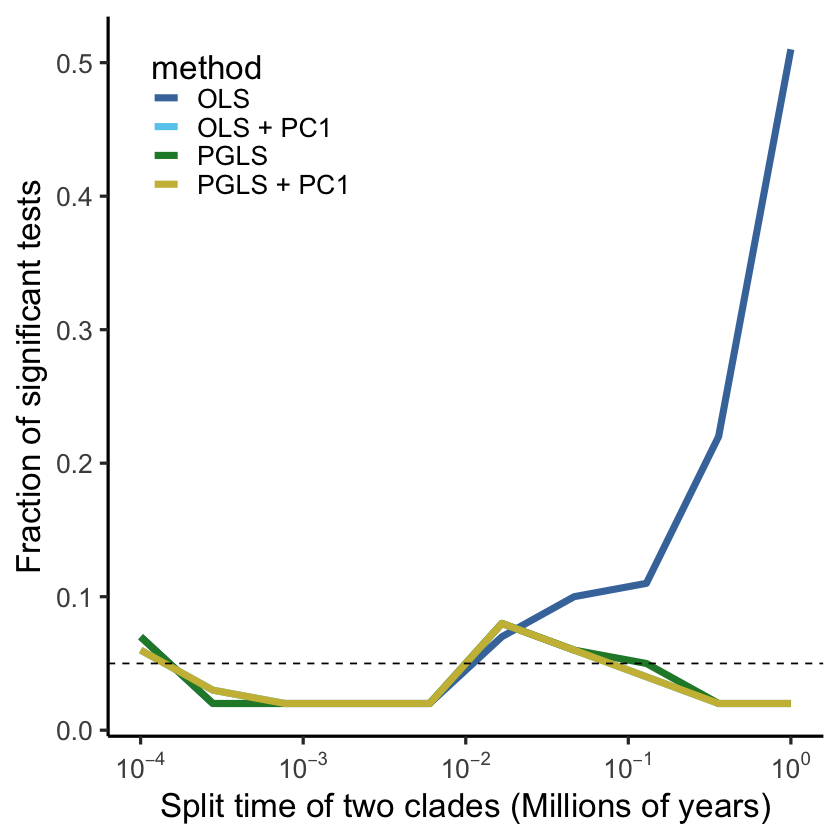

In [7]:
p_vals %>%
    group_by(method,divergence) %>%
    summarise(FPR = mean(p.value<0.05)) %>%
    mutate(method = 
        case_when(
            method=="lm" ~ "OLS",
            method=="lm_PC" ~ "OLS + PC1",
            method=="phylolm" ~ "PGLS",
            method=="phylolm_PC" ~ "PGLS + PC1"
        )
    ) %>%
    ggplot(aes(divergence,FPR)) +
    geom_line(aes(color=method),size=2) +
    scale_x_log10(labels=label_log()) +
    geom_hline(yintercept=0.05,lty=2) +
    theme_classic(base_size=20) +
    theme(legend.position=c(.2,.85),legend.spacing.y = unit(1,"pt")) +
    xlab("Split time of two clades (Millions of years)") +
    ylab("Fraction of significant tests") +
     scale_color_manual(values=c("#4477AA","#66CCEE","#228833","#CCBB44"),breaks = c("OLS","OLS + PC1", "PGLS", "PGLS + PC1"))

In [8]:
#Simulate environmental shift
s1 = stree(100,type="star")
s2 = stree(100,type="star")
s1$tip.label = paste(s1$tip.label,"_1")
s2$tip.label = paste(s2$tip.label,"_2")
s1$edge.length=rep(1,length(s1$tip.label))
s2$edge.length=rep(1,length(s2$tip.label))

num_rep = 100
s2shift = 10^(seq(log10(1e-4),log10(1e4),len=10))

p_vals_shift = tibble()

divergence = .15
s1$root.edge=divergence
s2$root.edge=divergence

combined_tree = s1+s2

PC1 = eigen(vcv(combined_tree))$vectors[,1]

for (i in 1:length(s2shift)) {
    message(i)
    for (j in 1:num_rep) {
        BM = fastBM(combined_tree,1,nsim=2)
        X = BM[,1]
        Y = BM[,2]
        
        tree_1_tips = grep("_1",row.names(BM))
        
        X[tree_1_tips] = X[tree_1_tips] + rnorm(1,0,sd=sqrt(s2shift[i]))
        Y[tree_1_tips] = Y[tree_1_tips] + rnorm(1,0,sd=sqrt(s2shift[i]))
        
        
        all_data = as.data.frame(tibble(X = X, Y = Y,PC1=PC1))
        rownames(all_data) = rownames(BM)
        
        cur_lm = lm(Y ~ X,data=all_data)
        cur_p = summary(cur_lm)$coefficients["X","Pr(>|t|)"]
        p_vals_shift = bind_rows(p_vals_shift,tibble(shift=s2shift[i],p.value=cur_p,rep=j,method="lm"))
        
        cur_lm = lm(Y ~ X + PC1,data=all_data)
        cur_p = summary(cur_lm)$coefficients["X","Pr(>|t|)"]
        p_vals_shift = bind_rows(p_vals_shift,tibble(shift=s2shift[i],p.value=cur_p,rep=j,method="lm_PC"))
        
        cur_lm = phylolm(Y ~ X,data=all_data,phy=combined_tree)
        cur_p = summary(cur_lm)$coefficients["X","p.value"]
        p_vals_shift = bind_rows(p_vals_shift,tibble(shift=s2shift[i],p.value=cur_p,rep=j,method="phylolm"))
        
        cur_lm = phylolm(Y ~ X + PC1,data=all_data,phy=combined_tree)
        cur_p = summary(cur_lm)$coefficients["X","p.value"]
        p_vals_shift = bind_rows(p_vals_shift,tibble(shift=s2shift[i],p.value=cur_p,rep=j,method="phylolm_PC"))
        
    }
    
}

1

2

3

4

5

6

7

8

9

10



`summarise()` has grouped output by 'method'. You can override using the `.groups` argument.


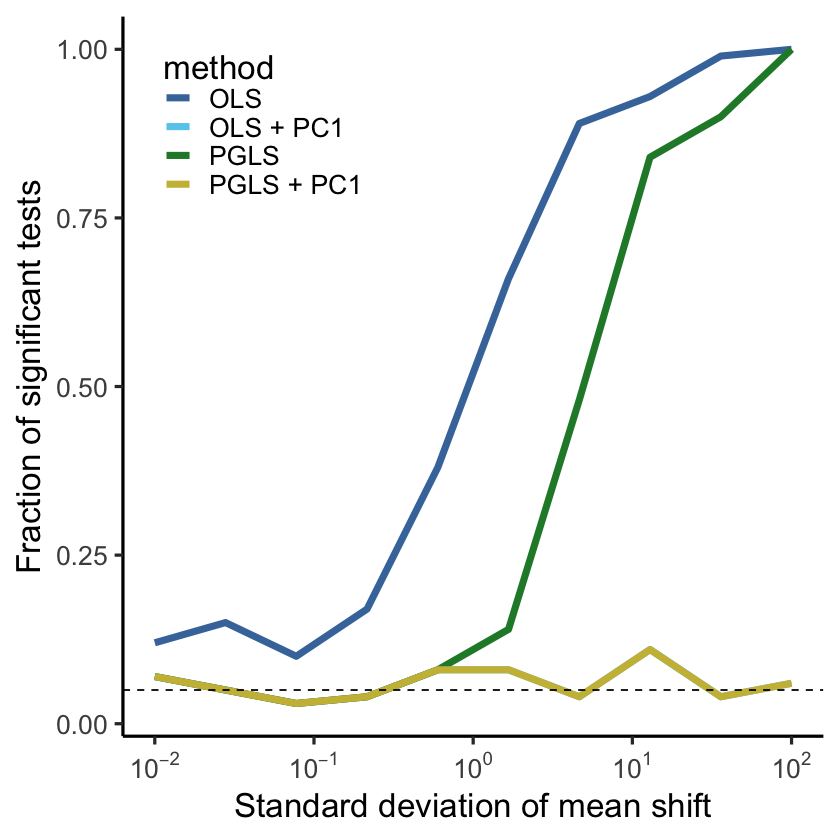

In [9]:
p_vals_shift %>%
    group_by(method,shift) %>%
    summarise(FPR = mean(p.value<0.05)) %>%
    mutate(method = 
        case_when(
            method=="lm" ~ "OLS",
            method=="lm_PC" ~ "OLS + PC1",
            method=="phylolm" ~ "PGLS",
            method=="phylolm_PC" ~ "PGLS + PC1"
        )
    ) %>%
    ggplot(aes(sqrt(shift),FPR)) +
    geom_line(aes(color=method),size=2) +
    scale_x_log10(labels=label_log()) +
    geom_hline(yintercept=0.05,lty=2) +
    theme_classic(base_size=20) +
    theme(legend.position=c(.2,.85),legend.spacing.y = unit(1,"pt")) +
    xlab("Standard deviation of mean shift") +
    ylab("Fraction of significant tests") +
    scale_color_manual(values=c("#4477AA","#66CCEE","#228833","#CCBB44"),breaks = c("OLS","OLS + PC1", "PGLS", "PGLS + PC1"))

In [10]:
#Simulate complicated phylogeny
um_rep = 500

p_vals_PC = tibble()
for (i in 1:num_rep) {
    message(i)
    
    tree = sim.bd.taxa(200,1,1,0,1,complete=FALSE)[[1]]
    tree$root.edge=0
    PCs = eigen(vcv(tree))$vectors

    colnames(PCs) = paste0("PC_",1:ncol(PCs))
    PCs = as_tibble(PCs)

    num_PC = 50
    PC_sets = lapply(1:num_PC,function(i){paste0("PC_",1:i)})
    PC_sets = c("1",PC_sets)
    
    BM = fastBM(tree,1,nsim=2)
    X = BM[,1]
    Y = BM[,2]
    
    all_data = as.data.frame(bind_cols(tibble(X = X, Y = Y),PCs))
    
    rownames(all_data) = rownames(BM)
    
    for (j in 1:length(PC_sets)) {
        cur_formula = as.formula(paste(c("Y ~ X", PC_sets[[j]]),collapse=" + "))
        
        cur_lm = lm(cur_formula,data=all_data)
        cur_p = summary(cur_lm)$coefficients["X","Pr(>|t|)"]
        p_vals_PC = bind_rows(p_vals_PC,tibble(PCs=j-1,p.value=cur_p,rep=i,method="lm"))
        
        cur_lm = phylolm(cur_formula,data=all_data,phy=tree)
        cur_p = summary(cur_lm)$coefficients["X","p.value"]
        p_vals_PC = bind_rows(p_vals_PC,tibble(PCs=j-1,p.value=cur_p,rep=i,method="phylolm"))
    }
}

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

90

91

92

93

94

95

96

97

98

99

100



`summarise()` has grouped output by 'method'. You can override using the `.groups` argument.


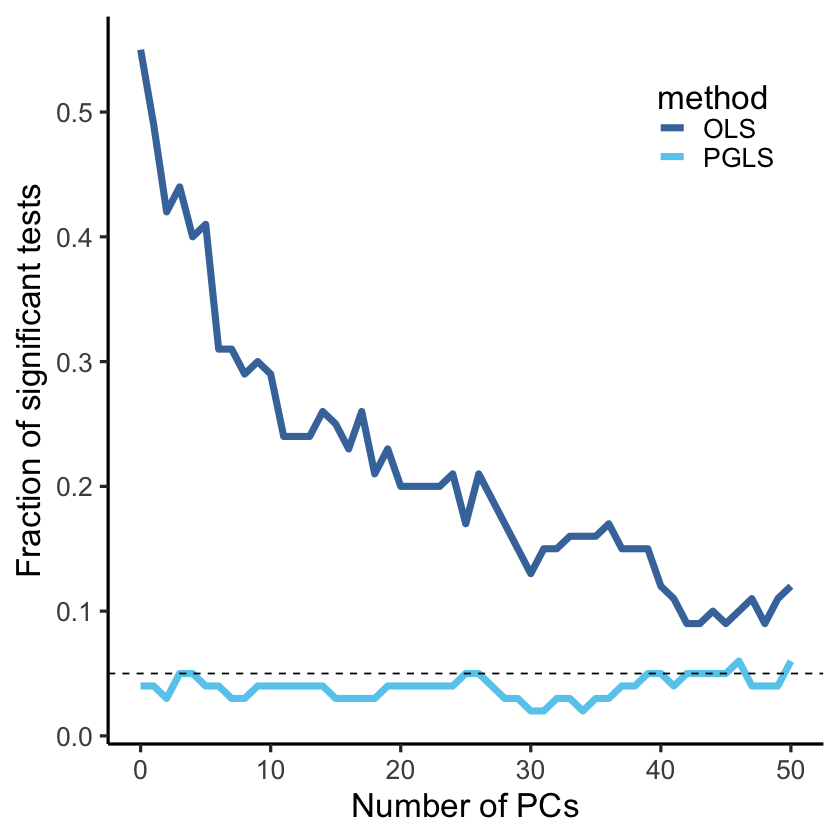

In [11]:
p_vals_PC %>%
    group_by(method,PCs) %>%
    summarise(FPR = mean(p.value<0.05)) %>%
    mutate(method=ifelse(method=="phylolm","PGLS","OLS")) %>% 
    ggplot(aes(PCs,FPR)) +
    geom_line(aes(color=method),size=2) +
    theme_classic(base_size=20) +
    xlab("Number of PCs") +
    ylab("Fraction of significant tests") +
    geom_hline(yintercept=0.05,lty=2) +
    theme(legend.position=c(.85,.85),legend.spacing.y = unit(1,"pt")) +
    scale_color_manual(values=c("#4477AA","#66CCEE","#228833","#CCBB44"), breaks = c("OLS","PGLS"))